## CrowdED: Crowdsourcing task optimization
---
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

*This notebook takes step by step the construction of the crowdED module*

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---

### Tasks Generator Module

In our simulation, the task is that the worker has to choose one out of the five given answers. Here, we simulate the true answer for each worker-task pair.

It is needed one of the keys for the answer

In [2]:
import sys
import numpy as np
import pandas as pd
import shortuuid as uid
import crowded.key_words as kw

KEYS = 7
HARD = 0.3
LEN = 12
N = 10

class Tasks(object):
    def __init__(self, keys=KEYS, length=LEN):
        """
        :param keys: number of key words for the assessment
        :type keys: python list or numpy array of any stringable objects
        :param length: length of the identifier
        :type length: int
        """
        self.length = length
        self.keys = keys

    def _generate_tasks(self, n=N):
        """
        :param n: number of tasks to be generated (default value: 10)
        :type n: int
        """
        return ['task_' + uid.ShortUUID().random(length=self.length) for i in range(n)]

    def _random_words(self):
        return [i for i in np.random.choice(kw.words(), self.keys, replace=False)]

    def _true_answer(self, n=N):
        """
        :param n: number of true answers to be generated (default value: 10)
        :type n: int
        """
        return [answer for answer in np.random.choice(self._random_words(), n)]

    def create(self, n=N, h=HARD):
        """
        :param n: number of tasks to be generated (default value: 10)
        :type n: int
        :param h: proportion of hard tasks a priori selected for the experiment (default value: 0.2)
        :type h: float
        """
        e = 1 - h
        cut_tasks = 0.5
        tasks = self._generate_tasks(n)
        probs_tasks = []
        easy_tasks = [task for task in np.random.choice(
            tasks, int(round(e * n, 0)), replace=False)]
        hard_tasks = [task for task in set(tasks) - set(easy_tasks)]
        df = pd.DataFrame()
        df['task_id'] = tasks
        df['true_answers'] = self._true_answer(n)
        df['label_task'] = ['hard_task' if tasks[i]
                            in hard_tasks else 'easy_task' for i in range(n)]
        for i in df['label_task']:
            if i == 'easy_task':  # uniform from .75 to 1
                probs_tasks.append(np.random.choice(
                    (np.arange(cut_tasks, 1, 0.01)), 1))
            elif i == 'hard_task':  # uniform from .5 to .75
                probs_tasks.append(np.random.choice(
                    (np.arange(0, cut_tasks, 0.01)), 1))
            else:
                probs_tasks.append(1)

        df['prob_task'] = [item for prob in probs_tasks for item in prob]
        return df

### Tasks Generation

In [3]:
total_tasks = 415 #342 #100
total_workers = 40 #50 #30
p_hard_tasks = 0.4
number_of_keys = 5

In [4]:
df_tasks = Tasks(number_of_keys).create(total_tasks, p_hard_tasks)
df_tasks.head()

,task_id,true_answers,label_task,prob_task
0,task_EdKRYZFwuYmv,twine,easy_task,0.68
1,task_tcg5ukEXCXzA,directories,hard_task,0.44
2,task_aUFWvXKfCL9p,directories,hard_task,0.11
3,task_VZ6UPFjU3ySr,diagram,hard_task,0.49
4,task_2WRgGffo23Fa,twine,easy_task,0.87


### Workers and Distribution Module

In [5]:
import sys
import pandas as pd
import shortuuid as uid
from scipy.stats import beta

LEN = 12
N = 10
a = 28
b = 3

class Workers(object):
    def __init__(self, alpha=a, beta=b, length=LEN):
        """
        :param alpha: parameter alpha of a beta distribution (default value: 28)
        :type alpha: float
        :param beta: parameter beta of a beta distribution (default value: 3)
        :type beta: float
        :param length: number of workers to be created (default value:10)
        :type length: type
        """
        self.length = length
        self.alpha = alpha
        self.beta = beta

    def create(self, n=N):
        df = pd.DataFrame(
            {'worker_id': [uid.ShortUUID().random(self.length) for i in range(n)],
             'prob_worker': beta.rvs(self.alpha, self.beta, size=n)})
        return df

### Workers Generation

In [6]:
df_workers = Workers().create(total_workers)
df_workers.head()

,prob_worker,worker_id
0,0.876318,VYeCx9NUPFZA
1,0.838609,TynAmfDdvEFA
2,0.922775,uSkRo4YZq9DR
3,0.931893,sPz8yLA5hB3y
4,0.934112,jVozModDMPCT


---
In this step, we first calculate the exact probabilities of getting the answer right for each worker and each task.

Since the ability is unknown before the task is undertaken, we use a beta distribution to model the distribution of worker ability. Its probability density function $f(x|a, v)$ is given by 

$$
f(x|a,v) = Beta (\frac{a}{\min(a,1-a)v}, \frac{(1-a)}{\min(a,1-a)v})
$$

Here a ∈ (0, 1) is the normalized value of the average ability of the workers in the crowdsourcing platform.  
v ∈ (0, 1) is a parameter that determines the variance in worker ability  
[Paper](https://aaai.org/ocs/index.php/HCOMP/HCOMP16/paper/viewFile/14047/13632)  

Mean probability 0.9033984344528895


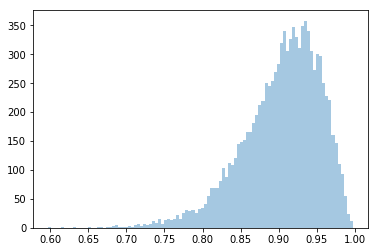

In [7]:
data_beta = beta.rvs(28, 3, size=10000)
sns.distplot(data_beta, kde=False, bins=100)
print('Mean probability {}'.format(np.mean(data_beta)))

In general we have good workers, on average the 90% of chances to getting the answer right

---

#### Summary of aggregated probabilities

In [8]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.744056   249
hard_task   0.229096   166

In [9]:
df_workers.describe()

,prob_worker
count,40.000000
mean,0.894199
std,0.051595
min,0.787610
25%,0.850577
50%,0.910112
75%,0.932448
max,0.978764


--- 

### Creating a task-worker assignation

this function has to eat btw the 2 df result from the previous functions

In [10]:
import pandas as pd
import numpy as np

WPT = 3

class AssignTasks(object):
    def __init__(self, tasks, workers, wpt=WPT):
        """
        :param tasks: table created usings Tasks().create() object
        :type tasks: pandas dataframe
        :param workers: table created using Workers().create object
        :type workers: pandas dataframe
        :param wpt: number of workers per task for the simulation
        "param type: integer
        """
        self.wpt = wpt
        self.tasks = tasks
        self.workers = workers

    def _worker_assign(self):
        if self.wpt > len(self.workers):
            raise Exception(
                'Number of workers per task must be smaller than the number of workers!')
        return [worker for i in [np.random.choice(self.workers.worker_id, self.wpt, replace=False) for task in self.tasks.task_id] for worker in i]

    def _task_asssign(self):
        if self.wpt % 2 == 0:
            raise Exception('Number of workers per task must be odd!')
        return [item for k in [[self.tasks.task_id[i]] * self.wpt for i in range(len(self.tasks.task_id))] for item in k]
    
    def create(self):
        df = pd.DataFrame({'task_id': self._task_asssign(),
                           'worker_id': self._worker_assign()})
        df = pd.merge(df, self.tasks, on='task_id', how='left')
        df = pd.merge(df, self.workers, on='worker_id', how='left')
        return df

In [11]:
wpt = 5
#workers per task always smaller than the number of workers

In [12]:
df_tw = AssignTasks(df_tasks, df_workers, wpt).create()
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker
0,task_EdKRYZFwuYmv,QefBXNSexNeo,twine,easy_task,0.68,0.921782
1,task_EdKRYZFwuYmv,VoTTu2CnicrH,twine,easy_task,0.68,0.926076
2,task_EdKRYZFwuYmv,2rqzbp4pUHtU,twine,easy_task,0.68,0.852027
3,task_EdKRYZFwuYmv,M7rHvXC2xU6g,twine,easy_task,0.68,0.939961
4,task_EdKRYZFwuYmv,TynAmfDdvEFA,twine,easy_task,0.68,0.838609


In [13]:
#aggregation of the tasks
_agg = df_tw.groupby('worker_id').agg('count')['task_id']
_agg.name = 'tasks'

In [14]:
# REVIEW THIS, HOW DO WE MAKE SURE ALL THE WORKERS HAVE TASK ASIGNATED
_agg.sort_values(ascending=False).head()

worker_id
dxjyVQDqo6wP    67
dKmAZdmJLvtp    64
QefBXNSexNeo    64
UaYNALTkqmo7    62
S6j9faewyzAv    59
Name: tasks, dtype: int64

---
### Probabilities of getting the answer right

w = worker answer correct  
T = Having knowledge to do the task


$$
P(w~|~T) = \frac{P(T~|~w) P(w)}{P(T~|~w) P(w) + P(T~|~w^c) P(w^c)}
$$

[Bayes for conditional probability example](http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm)

Class propuse:  
Based on two vectors (pandas series same lenght) of probabilities create a conditional probability  
one vector for person, another for activity in this case workers and tasks
This new conditional prob is the prior probability for a Bernoulli likelihood  
Then the predicion will tell if the answer was right or not  

The Bernoulli is the posterior function to modelate the action

In [15]:
keys = df_tasks['true_answers'].unique()

In [16]:
keys

array(['twine', 'directories', 'diagram', 'clamps', 'eve'], dtype=object)

In [17]:
import pandas as pd
from scipy.stats import bernoulli

class ComputeProbability(object):
    def __init__(self, series1, series2, keys, size=1):
        self.size = size
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
        
    def _random_selection(self):
        return 1/len(self.keys)
    
    def _bayes_prob(self):
        if len(self.series1) != len(self.series2):
            raise Exception("Probability series expected to be the same size")
        return (self.series1*self.series2) / (self.series1*self.series2 + self._random_selection()*(1-self.series2))
    
    def predict(self):
        return pd.Series([bernoulli.rvs(size=self.size, p=prob)[0] for prob in self._bayes_prob()])

In [18]:
cp = ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)

In [39]:
#cp._bayes_prob()

In [42]:
#pd.Series([bernoulli.rvs(size=1, p=prob)[0] for prob in cp._bayes_prob()])

In [26]:
import numpy as np

class WorkerAnswer(object):
    def __init__(self, series1, series2, keys):
        """
        series1 = vector of true values correspondet to 1
        series2 = vector of 1 and 0
        key = vector of odd number of strings
        """
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
    
    def match(self):
        answers = []
        for idx, i in enumerate(self.series1):
            if i == 1:
                answers.append(self.series2.loc[idx])
            else:
                answers.append(np.random.choice([i for i in set(self.keys)-set(self.series2.loc[idx])], 1)[0])

        return answers 

In [27]:
worker_answer = WorkerAnswer(cp.predict(), df_tw['true_answers'], keys)

In [29]:
df_tw['worker_answers'] = worker_answer.match()

In [31]:
df_tw.head(3)

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,worker_answers
0,task_EdKRYZFwuYmv,QefBXNSexNeo,twine,easy_task,0.68,0.921782,twine
1,task_EdKRYZFwuYmv,VoTTu2CnicrH,twine,easy_task,0.68,0.926076,twine
2,task_EdKRYZFwuYmv,2rqzbp4pUHtU,twine,easy_task,0.68,0.852027,twine


In [37]:
#worker_answer.match()

---
### Confusion Matrix for the answers

Based on [pycm](https://github.com/sepandhaghighi/pycm) analysis

In [70]:
from pycm import *

In [71]:
cm = ConfusionMatrix(df_tw['true_answers'].tolist(), df_tw['worker_answers'].tolist())

In [72]:
cm.matrix()

Predict          calendar cruisers departmentsspirals  thunder  
Actual
calendar         403      3        5        3        6        
cruisers         1        463      7        4        5        
departments      6        4        350      9        16       
spirals          3        8        7        369      3        
thunder          5        1        8        4        382      



In [73]:
cm.Overall_ACC

0.9479518072289157

In [74]:
cm.CrossEntropy

2.3172278710234933

In [75]:
cm.ACC

{'calendar': 0.984578313253012,
 'cruisers': 0.9840963855421687,
 'departments': 0.9701204819277108,
 'spirals': 0.9802409638554217,
 'thunder': 0.9768674698795181}

In [76]:
cm.FPR #False positive rate (FPR), Fall-out, probability of false alarm 

{'calendar': 0.009063444108761365,
 'cruisers': 0.010031347962382475,
 'departments': 0.015976331360946783,
 'spirals': 0.011869436201780381,
 'thunder': 0.017910447761193993}

In [77]:
cm.TPR #True positive rate (TPR), Recall, Sensitivity, probability of detection 

{'calendar': 0.9595238095238096,
 'cruisers': 0.9645833333333333,
 'departments': 0.9090909090909091,
 'spirals': 0.9461538461538461,
 'thunder': 0.955}

In [93]:
np.mean([i for i in cm.TPR.values()])

0.9468703796203796

In [78]:
cm.TNR #Specificity (SPC), Selectivity, True negative rate (TNR) 

{'calendar': 0.9909365558912386,
 'cruisers': 0.9899686520376175,
 'departments': 0.9840236686390532,
 'spirals': 0.9881305637982196,
 'thunder': 0.982089552238806}

In [79]:
cm.PPV #PPV(Precision or positive predictive value)   

{'calendar': 0.9641148325358851,
 'cruisers': 0.9665970772442589,
 'departments': 0.9283819628647215,
 'spirals': 0.9485861182519281,
 'thunder': 0.9271844660194175}

In [94]:
np.mean([i for i in cm.PPV.values()])

0.9469728913832423

In [80]:
cm.FOR

{'calendar': 0.0102595051297526,
 'cruisers': 0.01065162907268169,
 'departments': 0.020612485276796266,
 'spirals': 0.01245551601423489,
 'thunder': 0.010823812387251941}

In [81]:
cm.F1

{'calendar': 0.9618138424821002,
 'cruisers': 0.9655891553701773,
 'departments': 0.9186351706036745,
 'spirals': 0.9473684210526315,
 'thunder': 0.9408866995073891}

In [97]:
sum([i for i in cm.F1.values()])/len([i for i in cm.F1.values()])

0.9468586578031944

Comparing with Turicreate library

In [82]:
import turicreate as tc
sf_tw = tc.SFrame(data=df_tw)
conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])

In [83]:
conf_matrix.print_rows(25,)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   cruisers   |     thunder     |   5   |
|   thunder    |     calendar    |   5   |
|   calendar   |     thunder     |   6   |
| departments  |     cruisers    |   4   |
|   cruisers   |     calendar    |   1   |
|   calendar   |     cruisers    |   3   |
|   thunder    |     spirals     |   4   |
| departments  |     thunder     |   16  |
|   cruisers   |   departments   |   7   |
|   thunder    |     thunder     |  382  |
| departments  |     calendar    |   6   |
|   calendar   |     spirals     |   3   |
| departments  |     spirals     |   9   |
|   cruisers   |     cruisers    |  463  |
|   thunder    |     cruisers    |   1   |
|   spirals    |     thunder     |   3   |
|   calendar   |     calendar    |  403  |
|   spirals    |   departments   |   7   |
| departments  |   departments   |  350  |
|   thunder    |   departments   |   8   |
|   spirals

In [84]:
accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()

In [85]:
print(accuracy)

0.9479518072289157


---
### Measuring Performance and split the good workers from the rest

Next we measure the performance of the worker. The performance is calculate as the number of times a worker answers right (in comparison with the true answer) over the total number of workers per task.  

The range of the performance value spans from 0 to 1. The values close to 1 indicate that the majority of the workers had consensus. The values close to 0 indicate that there was no consensus.

In [98]:
df_tw['performance'] = cp.predict()

In [132]:
import pandas as pd

IDX = 'worker_id'

class Performance(object):
    def __init__ (self, df_tw):
        """
        :df_tw: dataframe of assigned tasks to workers
        """
        self.df_tw = df_tw
        
    def _agg(self):
        df = self.df_tw.groupby(IDX).agg('count')['task_id']
        df.index.name = 'tasks'
        return df
    
    def _workers(self):
        df = self.df_tw.groupby(self.df_tw[IDX]).mean().sort_values('performance', ascending=False)
        df['worker_hability'] = ['good_worker' if i == 1 else 'poor_worker' for i in df['performance']]
        return df.reset_index().join(self._agg(), on=IDX, how='left')
    
    def good_workers(self):
        _good = self._workers()[(self._workers()['worker_hability'] == 'good_worker') & ((self._workers()['prob_task'] < self._workers()['prob_task'].median()))]
        return [i for i in _good.index]

In [133]:
perf = Performance(df_tw)

In [134]:
perf._workers()

,worker_id,prob_task,prob_worker,performance,worker_hability,task_id
0,AuqkqAy4RZwV,0.537391,0.918534,1.000000,good_worker,46
1,qY5rnzVUp9qt,0.604857,0.930933,1.000000,good_worker,35
2,ijAes6s53tL7,0.563448,0.911642,1.000000,good_worker,58
3,fB3KCrYAwjhN,0.572364,0.959231,1.000000,good_worker,55
4,C7JbYz7P3iRF,0.623016,0.979580,0.984127,poor_worker,63
5,P6U8d2nfofqX,0.558542,0.954255,0.979167,poor_worker,48
6,jKVJzyBJhf7S,0.515345,0.936911,0.965517,poor_worker,58
7,9fmjZyLVM55p,0.512105,0.906871,0.964912,poor_worker,57
8,yfns2GZAUyHi,0.579107,0.958421,0.964286,poor_worker,56
9,zRgPszpFpmeU,0.615556,0.889090,0.962963,poor_worker,54


Prediction Correct 1934 of 2075


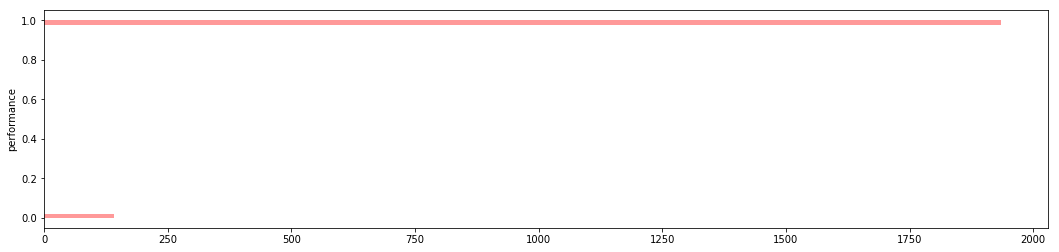

In [135]:
#Distribution performance
plt.figure(figsize=[18, 4])
sns.distplot(df_tw['performance'], kde=False, vertical=True, color="red")
print('Prediction Correct {} of {}'.format(df_tw['performance'].sum(), df_tw['performance'].count()))

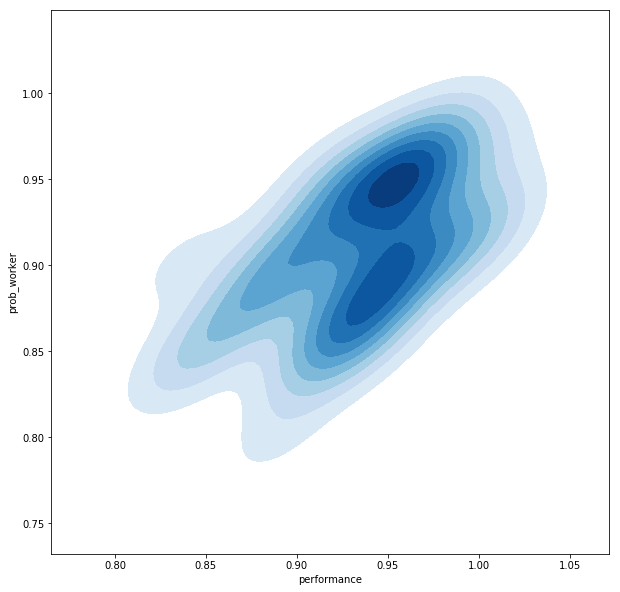

In [137]:
plt.figure(figsize=[10, 10])
sns.kdeplot(perf._workers()['performance'], perf._workers()['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

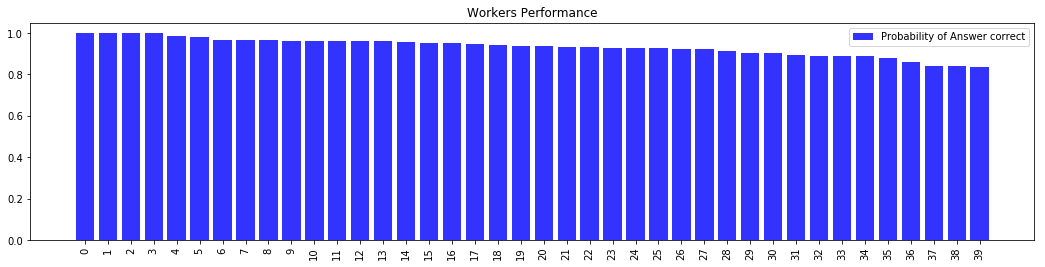

In [139]:
plt.figure(figsize=[18, 4])
axis = range(len(perf._workers()))
plt.bar(axis, perf._workers()['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, perf._workers().index, rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

In [140]:
perf._workers().describe()

,prob_task,prob_worker,performance,task_id
count,40.000000,40.000000,40.000000,40.000000
mean,0.548432,0.906282,0.932615,51.875000
std,0.036857,0.042362,0.044162,7.380458
min,0.491296,0.801034,0.836735,35.000000
25%,0.519939,0.873881,0.904855,47.750000
50%,0.545667,0.906156,0.937473,53.000000
75%,0.563409,0.939902,0.962963,57.000000
max,0.652075,0.979580,1.000000,71.000000


---
### Get Accuracy (Make Module)

In [1]:
import sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk

PTT = .3

def tasks_split(df, p=PTT):
    _train = df.sample(frac=p, random_state=23)
    _rest = df.loc[df.index.difference(_train.index)]
    return _train, _rest


def _update_progress(job_title, progress):
    length = 20
    block = int(round(length * progress))
    msg = "\r{0}: [{1}] {2}%".format(
        job_title, "#" * block + "-" * (length - block), round(progress * 100, 2))
    if progress >= 1:
        msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def crowd_table(total_tasks=100, total_workers=30, p_hard_tasks=0.4, ptt=.3, wpt=5, nk=5, a=10, b=1):
    df_tasks = cs.Tasks(nk).create(total_tasks, p_hard_tasks)
    workers = cs.Workers(a,b).create(total_workers)
    keys = df_tasks['true_answers'].unique()
    tasks_train, tasks_rest = tasks_split(df_tasks, ptt)
    df_tw = cs.AssignTasks(tasks_train, workers, wpt).create()
    cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
    df_tw['worker_answers'] = cm.WorkerAnswer(
        cp.predict(), df_tw['true_answers'], keys).match()
    df_tw['performance'] = cp.predict()
    perf = cm.Performance(df_tw)
    good_workers = workers.loc[perf.good_workers()]
    df_tw_2 = cs.AssignTasks(tasks_rest, good_workers, wpt).create()
    cp2 = cm.ComputeProbability(
        df_tw_2['prob_task'], df_tw_2['prob_worker'], keys)
    df_tw_2['worker_answers'] = cm.WorkerAnswer(
        cp2.predict(), df_tw_2['true_answers'], keys).match()
    df_tw_2['performance'] = cp2.predict()
    df = df_tw.append(df_tw_2)
    return df

In [2]:
#create crowd table one stage

In [ ]:
crowd_table(total_tasks=415, total_workers=40, p_hard_tasks=0.4, ptt=.3, wpt=5, nk=5, a=28, b=3)